In [1]:
%matplotlib notebook
import sys
sys.path.append("/home/stachu/Projects/Anomaly_detection/Forecasting_models")

from predpy.dataset import TimeSeriesRecordsDataset
from predpy.dataset import SingleTimeSeriesDataset, MultiTimeSeriesDataset
from predpy.data_module import MultiTimeSeriesModule
from predpy.experimentator import (
    DatasetParams, ModelParams, ExperimentatorPlot,
    Experimentator, load_experimentator, plot_aggregated_predictions)
from predpy.preprocessing import set_index
from predpy.preprocessing import moving_average
from predpy.preprocessing import (
    load_and_preprocess, set_index, moving_average, drop_if_is_in,
    use_dataframe_func, loc, iloc)
from predpy.trainer import (
    CheckpointParams, TrainerParams, EarlyStoppingParams, LoggerParams)
from tsad.noiser import apply_noise_on_dataframes, white_noise

import pickle
import numpy as np
import torch
from sklearn.preprocessing import MinMaxScaler
from tsai.models import TCN, ResNet, TST, RNN, TransformerModel, FCN
import pandas as pd
from pytorch_lightning.loggers import TensorBoardLogger
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from ipywidgets import *
from predpy.preprocessing.statistic_anomalies_detection import *
from models import LSTMAutoencoder
from predpy.wrapper import Autoencoder

<IPython.core.display.Javascript object>

In [2]:
model = LSTMAutoencoder(3, 400, 2)

# batch size, seq len, features
x = torch.randn(1, 2, 3)
model(x)

tensor([[[ 0.1635, -0.0303, -0.0815],
         [ 0.2577, -0.0407, -0.1196]]], grad_fn=<TransposeBackward0>)

# Experimentator run

In [3]:
window_size = 366

load_params = {
    "sep": ';', "header": 0, "low_memory": False,
    "infer_datetime_format": True, "parse_dates": {'datetime': [0, 1]},
    "index_col": ['datetime']
}

columns = ["Global_active_power", "Voltage"]
drop_refill_pipeline = [
    (loc, {"columns": columns}),
    (drop_if_is_in, (["?", np.nan]), {"columns": columns}),
    # (iloc, {"rows_end": 1500}),
    # (iloc, {"rows_start": -20000}),
]
preprocessing_pipeline = [
    (use_dataframe_func, "astype", "float"),
]
detect_anomalies_pipeline = [
#     (get_isoforest_filter, dict(
#         scores_threshold=-0.36, window_size=500, target="Global_active_power"))
]


datasets_params = [
    DatasetParams(
        path="/home/stachu/Projects/Anomaly_detection/Forecasting_models/data/Energy/household_power_consumption/household_power_consumption.csv",
        load_params=load_params,
        target="Global_active_power",
        split_proportions=[0.8, 0.1, 0.1],
        window_size=window_size,
        batch_size=64,
        DatasetCls=MultiTimeSeriesDataset,
        drop_refill_pipeline=drop_refill_pipeline,
        preprocessing_pipeline=preprocessing_pipeline,
        detect_anomalies_pipeline=detect_anomalies_pipeline,
        scaler=MinMaxScaler()),
]

c_in = 2
c_out = 1

models_params = [
    # ModelParams(
    #     name_="TST_l3_fcDrop0.1", cls_=TST.TST,
    #     init_params={
    #         "c_in": c_in, "c_out": c_out, "seq_len": window_size,
    #         "max_seq_len": window_size, "n_layers": 3, "fc_dropout": 0.1}),
    # ModelParams(
    #     name_="TST_l2_fcDrop0.1", cls_=TST.TST,
    #     init_params={
    #         "c_in": c_in, "c_out": c_out, "seq_len": window_size,
    #         "max_seq_len": window_size, "n_layers": 2, "fc_dropout": 0.1}),
    # ModelParams(
    #     name_="TST_l2_fcDrop0.0", cls_=TST.TST,
    #     init_params={
    #         "c_in": c_in, "c_out": c_out, "seq_len": window_size,
    #         "max_seq_len": window_size, "n_layers": 2, "fc_dropout": 0.0}),
    # ModelParams(
    #     name_="ResNet", cls_=ResNet.ResNet,
    #     init_params={"c_in": c_in, "c_out": c_out}),
    # ModelParams(
    #     name_="LSTM_h200_l2", cls_=RNN.LSTM,
    #     init_params={
    #         "c_in": c_in, "c_out": c_out, "hidden_size": 200, "n_layers": 2}),
    # ModelParams(
    #     name_="LSTM_h400_l1", cls_=RNN.LSTM,
    #     init_params={
    #         "c_in": c_in, "c_out": c_out, "hidden_size": 400, "n_layers": 1}),


    # ModelParams(
    #     name_="LSTM_h200_l1", cls_=RNN.LSTM,
    #     init_params={
    #         "c_in": c_in, "c_out": c_out, "hidden_size": 200, "n_layers": 1}),


    ModelParams(
        name_="LSTMAutoencoder_h400_l2", cls_=LSTMAutoencoder,
        init_params=dict(
            c_in=window_size, h_size=400, n_layers=1))
]

chp_p = CheckpointParams(
    dirpath="../checkpoints", monitor='val_loss', verbose=True,
    save_top_k=1)
tr_p = TrainerParams(
    max_epochs=1, gpus=1, auto_lr_find=True,
    logger=TensorBoardLogger("../lightning_logs"))
es_p = EarlyStoppingParams(
    monitor='val_loss', patience=2, verbose=True)

In [5]:
exp = Experimentator(
    models_params=models_params,
    datasets_params=datasets_params,
    trainer_params=tr_p,
    checkpoint_params=chp_p,
    early_stopping_params=es_p,
    WrapperCls=Autoencoder
)

exp.run_experiments(experiments_path="../saved_experiments", safe=False)

# exp = load_experimentator(
#     "../saved_experiments/2021-12-16_17:19:21.pkl")

Global seed set to 42
/home/stachu/anaconda3/envs/dl/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:446: UserWarning:

Checkpoint directory ../checkpoints/household_power_consumption/LSTMAutoencoder_h400_l2 exists and is not empty.

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/home/stachu/anaconda3/envs/dl/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:423: LightningDeprecationWarning:

DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type            | Params
----------------------------------------------
0 | model     | LSTMAutoencoder | 2.4 M 
1 | criterion | MSELoss         | 0     
----------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.413     Total

Global seed set to 42


Epoch 0: 100%|██████████| 27890/27890 [05:32<00:00, 83.90it/s, loss=0.000931, v_num=0:53, train_loss=0.00093, val_loss=0.000883]

Metric val_loss improved. New best score: 0.001
Epoch 0, global step 24790: val_loss reached 0.00088 (best 0.00088), saving model to "/home/stachu/Projects/Anomaly_detection/Forecasting_models/checkpoints/household_power_consumption/LSTMAutoencoder_h400_l2/2021-12-17_18:20:53.ckpt" as top 1


Epoch 0: 100%|██████████| 27890/27890 [05:32<00:00, 83.89it/s, loss=0.000931, v_num=0:53, train_loss=0.00093, val_loss=0.000883]


Making predictions: 100%|██████████| 3099/3099 [00:54<00:00, 56.85it/s]


ValueError: (AssertionError('1 columns passed, passed data had 2 columns'), 'Problem with training 0 model named LSTMAutoencoder_h400_l2 on 0 dataset named household_power_consumption')

# Data loading

In [4]:
tsm = exp.load_time_series_module(0)
df = pd.concat(tsm.sequences)
df = df.resample('1min').fillna("backfill")

In [15]:
import impyute as impy

tmp = pd.read_csv(
    "/home/stachu/Projects/Anomaly_detection/Forecasting_models/data/Energy/household_power_consumption/household_power_consumption.csv",
    **load_params
)

In [86]:
from predpy.preprocessing import load_and_preprocess

# DatasetParams(
#     path="/home/stachu/Projects/Anomaly_detection/Forecasting_models/data/Energy/household_power_consumption/household_power_consumption.csv",
#     load_params=load_params,
#     target="Global_active_power",
#     split_proportions=[0.8, 0.1, 0.1],
#     window_size=window_size,
#     batch_size=64,
#     DatasetCls=MultiTimeSeriesDataset,
#     drop_refill_pipeline=drop_refill_pipeline,
#     preprocessing_pipeline=preprocessing_pipeline,
#     detect_anomalies_pipeline=detect_anomalies_pipeline,
#     scaler=MinMaxScaler()),
ds_params = datasets_params[0]
df = load_and_preprocess(
    dataset_path=ds_params.path,
    load_params=ds_params.load_params,
    drop_refill_pipeline=ds_params.drop_refill_pipeline,
    preprocessing_pipeline=ds_params.preprocessing_pipeline,
    detect_anomalies_pipeline=ds_params.detect_anomalies_pipeline,
    drop_na_after_anomaly_detection=True,
    scaler=ds_params.scaler,
    training_proportion=ds_params.split_proportions[0])

In [87]:
df = df.resample('1min').asfreq()
df[df.isnull().any(axis=1)]

,Global_active_power,Voltage
datetime,,
2006-12-21 11:23:00,NaN,NaN
2006-12-21 11:24:00,NaN,NaN
2006-12-30 10:08:00,NaN,NaN
2006-12-30 10:09:00,NaN,NaN
2007-01-14 18:36:00,NaN,NaN
...,...,...
2010-09-28 19:09:00,NaN,NaN
2010-09-28 19:10:00,NaN,NaN
2010-09-28 19:11:00,NaN,NaN


In [81]:
import impyute as impy
from time import time
start = time()
res = impy.moving_window(
    data,
    wsize=df.loc["2006-12-21 11:10:00":"2006-12-21 11:40:00"].shape[0],
    nindex=13
)
end = time() - start
res[-19:-15]

array([[0.01520913, 0.61680129],
       [       nan,        nan],
       [0.015     , 0.61      ],
       [0.01539019, 0.59903069]])

In [93]:
tmp = df.loc["2006-12-21 11:10:00":"2006-12-21 11:40:00"].interpolate(method="akima")
tmp.loc["2006-12-21 11:21:00":"2006-12-21 11:26:00"]

,Global_active_power,Voltage
datetime,,
2006-12-21 11:21:00,0.015028,0.596769
2006-12-21 11:22:00,0.015209,0.616801
2006-12-21 11:23:00,0.015283,0.612403
2006-12-21 11:24:00,0.015344,0.604376
2006-12-21 11:25:00,0.015390,0.599031
2006-12-21 11:26:00,0.015390,0.601939


In [74]:
len(res)

31

In [57]:
dir(impy)

['__all__',
 '__author__',
 '__build__',
 '__builtins__',
 '__cached__',
 '__copyright__',
 '__doc__',
 '__file__',
 '__license__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '__title__',
 '__version__',
 'complete_case',
 'deletion',
 'em',
 'fast_knn',
 'imputation',
 'locf',
 'mean',
 'median',
 'mice',
 'mode',
 'moving_window',
 'random',
 'util']

In [61]:
res[-19:-15]

array([[0.01520913, 0.61680129],
       [0.01575231, 0.54345719],
       [0.04399783, 0.56122779],
       [0.01539019, 0.59903069]])

In [54]:
df.loc["2006-12-21 11:10:00":"2006-12-21 11:40:00"]

,Global_active_power,Voltage
datetime,,
2006-12-21 11:10:00,0.023538,0.526333
2006-12-21 11:11:00,0.023357,0.527625
2006-12-21 11:12:00,0.046352,0.573829
2006-12-21 11:13:00,0.145030,0.510824
2006-12-21 11:14:00,0.081296,0.530533
2006-12-21 11:15:00,0.043998,0.543457
2006-12-21 11:16:00,0.015752,0.553150
2006-12-21 11:17:00,0.014847,0.561228
2006-12-21 11:18:00,0.015028,0.579321


In [21]:
tmp = tmp[["Global_active_power", "Global_reactive_power"]]
# impy.mean(tmp.to_numpy())

ValueError: could not convert string to float: '?'

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

# fig = plt.figure(figsize=(16, 7))

result = seasonal_decompose(
    df["Global_active_power"],
    model='additive', period=1440,
    extrapolate_trend='freq')
# fig = result.plot()
# fig.set_size_inches(12, 5)

## Testing fillna method

In [ ]:
# start = tsm.sequences[0].index[-1]
# for seq in tsm.sequences[1:]:
#     end = seq.index[0]
#     df.loc[start:end].plot()
#     start = seq.index[-1]

# Statistical anomaly detection plotting

## Collective Isolation Forest

In [ ]:
# scores, if_model = collective_isolation_forest(ts, window_size, return_model=True)
# scores = collective_isolation_forest(df["Global_active_power"], 500)
scores = collective_isolation_forest(tsm.sequences[0]["Global_active_power"], 500)

In [ ]:
df

In [ ]:
None = 1

In [ ]:
threshold_widget = FloatSlider(
    value=-0.5,
    min=-1,
    max=0,
    step=0.001,
    description='Threshold',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
)

plot_interact_filtering(
    ts=tsm.sequences[0]["Global_active_power"], widgets={
        "scores_threshold": threshold_widget},
    filter_f=get_isoforest_filter, title="Remove isolation forest outliers",
    scores=scores);

## DWT clustering

In [ ]:
ts_distance_matrix(df["Global_active_power"], 1000000, True)

## Residual outliers

In [ ]:
threshold_widget = FloatSlider(
    value=0.7,
    min=min(result.resid),
    max=max(result.resid),
    step=(max(result.resid) - min(result.resid))/100,
    description='Threshold',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
)

plot_interact_filtering(
    ts=tsm.sequences[0]["Global_active_power"], widgets={
        "residual_threshold": threshold_widget},
    filter_f=get_residual_filter, title="Remove residual outliers",
    residuals=result.resid);

## Variance

In [ ]:
tmp = get_variance_filter(
    df["Global_active_power"], window_size=5000, log_variance_limits=(-4.6, -2))

In [ ]:
df.loc["2008-08-02 00:00:00":"2008-08-31 00:00:00"]

In [ ]:
tmp = df["Global_active_power"].rolling(window=window_size, center=True).var()

%matplotlib inline
plt.cla()
tmp.loc["2008-07-16 17:24:00":"2008-09-20 17:24:00"].plot()
# df["Global_active_power"].loc["2008-07-16 17:24:00":"2008-09-20 17:24:00"].plot()
plt.show()

<IPython.core.display.Javascript object>


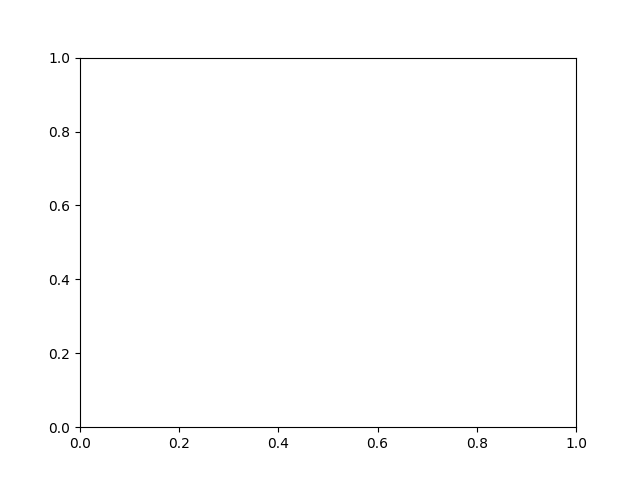

<IPython.core.display.Javascript object>


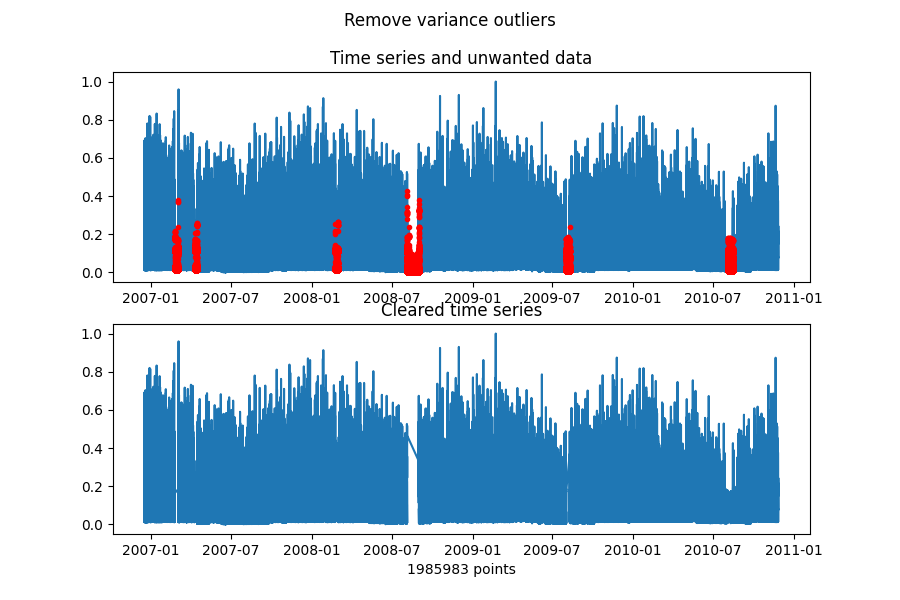

interactive(children=(IntSlider(value=30000, continuous_update=False, description='Window size', max=100000, m…

In [94]:
window_size_w = IntSlider(
    value=30000,
    min=100,
    max=100000,
    step=1,
    description='Window size',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True
)

log_var_w = FloatRangeSlider(
    value=[-8.40, -2],
    min=-10,
    max=-2,
    step=0.1,
    description='Log variance',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True
)

plt.cla()
plot_interact_filtering(
    ts=df["Global_active_power"],
    widgets={
        "window_size": window_size_w,
        "log_variance_limits": log_var_w},
    filter_f=get_variance_filter, title="Remove variance outliers")

In [95]:
np.exp(-7)

0.0009118819655545162

# Tslearn testing

In [ ]:
from tslearn.clustering import TimeSeriesKMeans
model = TimeSeriesKMeans(n_clusters=3, metric="dtw", max_iter=10)
model.fit(df)

In [ ]:
import matplotlib.pyplot as plt
y_pred = model.predict(ts)
sz = ts.shape[1]

plt.figure()
for yi in range(3):
    plt.subplot(3, 1, 1 + yi)
    xx = ts[y_pred == yi]
    plt.plot(xx, "k-", alpha=.2)
    # plt.xlim(0, sz)
    # plt.ylim(-4, 4)
    plt.title("Cluster %d" % (yi + 1))

plt.tight_layout()
plt.show()

In [ ]:
import numpy
import matplotlib.pyplot as plt

from tslearn.clustering import KernelKMeans
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

seed = 0
numpy.random.seed(seed)
X_train, y_train, X_test, y_test = CachedDatasets().load_dataset("Trace")
# Keep first 3 classes
X_train = X_train[y_train < 4]
numpy.random.shuffle(X_train)
# Keep only 50 time series
X_train = TimeSeriesScalerMeanVariance().fit_transform(X_train[:50])
sz = X_train.shape[1]

gak_km = KernelKMeans(n_clusters=3,
                      kernel="gak",
                      kernel_params={"sigma": "auto"},
                      n_init=20,
                      verbose=True,
                      random_state=seed)
y_pred = gak_km.fit_predict(X_train)

plt.figure()
for yi in range(3):
    plt.subplot(3, 1, 1 + yi)
    for xx in X_train[y_pred == yi]:
        print(xx.ravel())
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.title("Cluster %d" % (yi + 1))

plt.tight_layout()
plt.show()

# Isolation Forest testing

In [ ]:
from sklearn.ensemble import IsolationForest

df = pd.concat(tsm.sequences)[["Global_active_power"]]
gap = (df['Global_active_power'].values.reshape(-1,1))
model_isoforest = IsolationForest()
model_isoforest.fit(gap)
scores = model_isoforest.score_samples(gap)
df['anomaly_scores'] = model_isoforest.score_samples(gap)
df['anomaly_classification'] = model_isoforest.predict(
    df['Global_active_power'].values.reshape(-1,1))

In [ ]:
df[df["anomaly_scores"] < -0.8]

In [ ]:
sub_df[(sub_df["anomaly_scores"] > -0.8) & (sub_df["Global_active_power"] > 0.609451)][["Global_active_power"]]

In [ ]:
# pd.options.plotting.backend = "plotly"
# df["anomaly_classification"] = df["anomaly_classification"].apply(lambda x: x - 3)
# ax = pd.DataFrame.plot()
# df[df["anomaly_scores"] > -0.40727][["Global_active_power"]].reset_index().plot(figsize=(25, 7), colormap="red", x="datetime", y="anomaly_classification", kind="scatter")
from matplotlib import pyplot as plt

plt.figure(figsize=(25, 7))

step = 5000
i = 9

sub_df = df[i*step:(i+1)*step]
plt.subplot(211)
plt.plot(sub_df[sub_df["anomaly_scores"] < -0.8][["Global_active_power"]].index, sub_df[sub_df["anomaly_scores"] < -0.8]["Global_active_power"], 'bo', color="red");
plt.plot(sub_df["Global_active_power"].index, sub_df["Global_active_power"]);

plt.subplot(212)
plt.plot(sub_df[sub_df["anomaly_scores"] >= -0.8].index, sub_df[sub_df["anomaly_scores"] >= -0.8]["Global_active_power"]);

In [ ]:
None = 1

# Anomaly predictor testing

In [ ]:
normal_dfs = tsm.get_data_from_range(start=-1000, end=-500, copy=True)
anomaly_dfs = tsm.get_data_from_range(start=-500, copy=True)

In [ ]:
anomaly_dfs[0].plot();

In [ ]:
apply_noise_on_dataframes(
    anomaly_dfs, make_noise=white_noise, negativity="abs", loc=0, scale=0.4)
anomaly_dfs[0].plot();

In [ ]:
from tsad.anomaly_detector import PredictionAnomalyDetector

model = exp.load_pl_model(
    model_idx=0,
    dir_path="../checkpoints/household_power_consumption/LSTM_h200_l1")

ad = PredictionAnomalyDetector(model)

ad.fit(
    train_data=DataLoader(
        MultiTimeSeriesDataset(normal_dfs, tsm.window_size, tsm.target),
        batch_size=tsm.batch_size),
    anomaly_data=DataLoader(
        MultiTimeSeriesDataset(anomaly_dfs, tsm.window_size, tsm.target),
        batch_size=tsm.batch_size),
    normal_data=DataLoader(
        MultiTimeSeriesDataset(normal_dfs, tsm.window_size, tsm.target),
        batch_size=tsm.batch_size),
    class_weight={0: 0.8, 1: 0.2}, verbose=True, plot=True
)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


anomaly_data=DataLoader(
    MultiTimeSeriesDataset(anomaly_dfs, tsm.window_size, tsm.target),
    batch_size=tsm.batch_size)
normal_data=DataLoader(
    MultiTimeSeriesDataset(normal_dfs, tsm.window_size, tsm.target),
    batch_size=tsm.batch_size)
normal_preds = ad._any_forward(normal_data, True)
anomaly_preds = ad._any_forward(anomaly_data, True)
plt.hist([
    ad.distributor.cdf(normal_preds).T[0], ad.distributor.cdf(anomaly_preds).T[0]],
    bins=30, label=["normal", "anomaly"]);

In [ ]:
# BTC = yf.Ticker("BTC-USD")
# # df = BTC.history(period="max", interval="1d", auto_adjust=False, actions=False)
# df = BTC.history(interval="1d", start="2014-09-17", end="2021-10-16", actions=False)
# df["Open-Close-diff"] = df.apply(lambda x: x["Close"] - x["Open"], axis=1)

# from datetime import datetime
# end = datetime.strptime("06-01-2017", '%m-%d-%Y')
# df = df.loc[:end]  # remove last years due to a change behaviour
# df = df[["Close", "Open-Close-diff"]]

In [1]:
import sys
sys.path.append("/home/stachu/Projects/Anomaly_detection/Forecasting_models")

from predpy.dataset import MultiTimeSeriesDataset
from predpy.data_module import MultiTimeSeriesModule
from predpy.wrapper import Autoencoder, Predictor
from predpy.experimentator import (
    DatasetParams, ModelParams, ExperimentatorPlot,
    Experimentator, load_experimentator, plot_aggregated_predictions)
from predpy.preprocessing import set_index
from predpy.preprocessing import moving_average
from predpy.preprocessing import (
    load_and_preprocess, set_index, moving_average, drop_if_is_in,
    use_dataframe_func, loc, iloc, get_isoforest_filter, get_variance_filter)
from predpy.trainer import (
    CheckpointParams, TrainerParams, EarlyStoppingParams, LoggerParams)
from tsad.noiser import apply_noise_on_dataframes, white_noise
from tsad.anomaly_detector import PredictionAnomalyDetector, ReconstructionAnomalyDetector
from models import LSTMAutoencoder

from pytorch_lightning.loggers import TensorBoardLogger
import pickle
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tsai.models import TCN, ResNet, TST, RNN, TransformerModel, FCN
import pandas as pd
from torch.utils.data import DataLoader, Dataset
from prophet import Prophet


# =============================================================================

window_size = 366

load_params = {
    "sep": ';', "header": 0, "low_memory": False,
    "infer_datetime_format": True, "parse_dates": {'datetime': [0, 1]},
    "index_col": ['datetime']
}

columns = ["Global_active_power", "Voltage"]
drop_refill_pipeline = [
    (loc, {"columns": columns}),
    (drop_if_is_in, (["?", np.nan]), {"columns": columns}),
    # (iloc, {"rows_end": 1500}),
    # (iloc, {"rows_start": -20000}),
]
preprocessing_pipeline = [
    (use_dataframe_func, "astype", "float"),
]
detect_anomalies_pipeline = [
    # (get_isoforest_filter, dict(
    #     scores_threshold=-0.36, window_size=500, target="Global_active_power"))
    (get_variance_filter, dict(
        window_size=5000, log_variance_limits=(-7, 0),
        target="Global_active_power"))
]


datasets_params = [
    DatasetParams(
        path="/home/stachu/Projects/Anomaly_detection/Forecasting_models/data/Energy/household_power_consumption/household_power_consumption.csv",
        load_params=load_params,
        target="Global_active_power",
        split_proportions=[0.8, 0.1, 0.1],
        window_size=window_size,
        batch_size=64,
        drop_refill_pipeline=drop_refill_pipeline,
        preprocessing_pipeline=preprocessing_pipeline,
        detect_anomalies_pipeline=detect_anomalies_pipeline,
        scaler=MinMaxScaler()),
]

c_in = 2
c_out = 1

models_params = [
    # ModelParams(
    #     name_="TST_l3_fcDrop0.1", cls_=TST.TST,
    #     init_params={
    #         "c_in": c_in, "c_out": c_out, "seq_len": window_size,
    #         "max_seq_len": window_size, "n_layers": 3, "fc_dropout": 0.1}),
    # ModelParams(
    #     name_="TST_l2_fcDrop0.1", cls_=TST.TST,
    #     init_params={
    #         "c_in": c_in, "c_out": c_out, "seq_len": window_size,
    #         "max_seq_len": window_size, "n_layers": 2, "fc_dropout": 0.1}),
    # ModelParams(
    #     name_="TST_l2_fcDrop0.0", cls_=TST.TST,
    #     init_params={
    #         "c_in": c_in, "c_out": c_out, "seq_len": window_size,
    #         "max_seq_len": window_size, "n_layers": 2, "fc_dropout": 0.0}),
    # ModelParams(
    #     name_="ResNet", cls_=ResNet.ResNet,
    #     init_params={"c_in": c_in, "c_out": c_out}),
    # ModelParams(
    #     name_="LSTM_h200_l1", cls_=RNN.LSTM,
    #     init_params={
    #         "c_in": c_in, "c_out": c_out, "hidden_size": 200, "n_layers": 1}),
    # ModelParams(
    #     name_="LSTM_h200_l2", cls_=RNN.LSTM,
    #     init_params={
    #         "c_in": c_in, "c_out": c_out, "hidden_size": 200, "n_layers": 2}),
    ModelParams(
        name_="LSTM_h400_l1", cls_=RNN.LSTM,
        init_params={
            "c_in": c_in, "c_out": c_out, "hidden_size": 400, "n_layers": 1}),
    # ModelParams(
    #     name_="LSTMAutoencoder_h400_l1", cls_=LSTMAutoencoder,
    #     init_params=dict(
    #         c_in=window_size, h_size=400, n_layers=1),
    #     WrapperCls=Autoencoder)
]

chp_p = CheckpointParams(
    dirpath="../checkpoints", monitor='val_loss', verbose=True,
    save_top_k=1)
tr_p = TrainerParams(
    max_epochs=1, gpus=1, auto_lr_find=True)
es_p = EarlyStoppingParams(
    monitor='val_loss', patience=2, verbose=True)

# import pytorch_lightning as pl
# from pytorch_lightning.loggers import TensorBoardLogger

# tmp = pl.Trainer(logger=TensorBoardLogger("./"))

exp = Experimentator(
    models_params=models_params,
    datasets_params=datasets_params,
    trainer_params=tr_p,
    checkpoint_params=chp_p,
    early_stopping_params=es_p,
    LoggersClasses=[TensorBoardLogger],
    loggers_params=[LoggerParams(save_dir="../lightning_logs")]
)

exp.run_experiments(experiments_path="../saved_experiments", safe=False)

Global seed set to 42
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/home/stachu/anaconda3/envs/dl/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:423: LightningDeprecationWarning:

DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type    | Params
--------------------------------------
0 | model     | LSTM    | 646 K 
1 | criterion | MSELoss | 0     
--------------------------------------
646 K     Trainable params
0         Non-trainable params
646 K     Total params
2.587     Total estimated model params size (MB)


Global seed set to 42


Epoch 0:   1%|          | 285/26486 [00:20<31:58, 13.66it/s, loss=0.0124, v_num=5:56, train_loss=0.013] 

/home/stachu/anaconda3/envs/dl/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1051: UserWarning:

Detected KeyboardInterrupt, attempting graceful shutdown...



FileNotFoundError: [Errno 2] No such file or directory: '../checkpoints/household_power_consumption/LSTM_h400_l1'

Epoch 0:   1%|          | 285/26486 [00:39<1:00:39,  7.20it/s, loss=0.0124, v_num=5:56, train_loss=0.013]